# Steinschlagrisiko cwm1

## Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


## Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0
NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## Abgabe
Form der Abgabe
Quellcode der Berechnungen in einem Notebook (R oder Jupyter).

Kurzer Bericht (max 8 Seiten) der die Berechnungen klar und nachvollziebar beschreibt und die Empfehlung an den Kantonsingenieur begründet.

### Abgabetermin
Montag, 10. Januar 2022

## 1. Bibliotheken Importieren

In [1]:
import numpy as np
import random as rnd
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport

## 2. Daten einlesen

In [36]:
df1 = pd.read_csv("out_1.csv") # Daten einlesen
df2 = pd.read_csv("out_2.csv")

## 3. Daten Bereinigung und Bearbeiten

In [37]:
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]] # Datentabelle auswaehlen
df1 = df1.dropna() # entfernt alle Zeile die mit NA Werte
df1['Ablösungszone'] = 1 # Spalte Ablösungszone 1 hinzugefuegt

In [38]:
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"}) # Spaltenname aendern
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]] # Datentabelle auswaehlen
df2 = df2.dropna() # entfernt alle Zeile die mit NA Werte
df2['Ablösungszone'] = 2 #Spalte Ablösungszone 2 hinzugefuegt

In [39]:
df1.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,68.000000,68.000000,68.0
mean,628.632353,8.788235,1.0
std,695.884703,1.989189,0.0
min,12.000000,3.600000,1.0
25%,214.750000,7.300000,1.0
50%,402.500000,8.800000,1.0
75%,773.000000,10.125000,1.0
max,3104.000000,14.100000,1.0


## 4. Tabellen zusammenfuegen

In [40]:
frames = [df1, df2]
df3 = pd.concat(frames)
df3

,Datum,Uhrzeit,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01,09:00,194.0,8.4,1
1,2019-01-01,21:00,224.0,8.8,1
2,2019-01-02,14:00,3104.0,9.2,1
3,2019-01-04,15:00,228.0,8.0,1
4,2019-01-05,23:00,755.0,7.0,1
...,...,...,...,...,...
27,2019-03-20,10:00,16.0,42.1,2
28,2019-03-21,13:00,211.0,29.0,2
29,2019-03-24,16:00,3.0,42.3,2
30,2019-03-25,14:00,63.0,43.2,2


## 5. Kinetische Energie

In [41]:
liste_masse = [(x) for x in df3['Masse [kg]']]
liste_geschwindigkeit = [(x) for x in df3["Geschwindigkeit [m/s]"]]
liste_energie = [] 

for i in range(len(liste_masse)):
    energie = 0.5 * liste_masse[i] * liste_geschwindigkeit[i]**2 / 1000 # Kj ausrechnen
    energie = round(energie,1) # Rundung
    liste_energie.append(energie)
    
df3['Energie [kJ]'] = liste_energie

In [42]:
#df3.profile_report()

## 6. Statistik von df3

In [43]:
df3.describe()
df3.describe(include=['object'])
df3.describe(include='all')
df3

,Datum,Uhrzeit,Masse [kg],Geschwindigkeit [m/s],Ablösungszone,Energie [kJ]
0,2019-01-01,09:00,194.0,8.4,1,6.8
1,2019-01-01,21:00,224.0,8.8,1,8.7
2,2019-01-02,14:00,3104.0,9.2,1,131.4
3,2019-01-04,15:00,228.0,8.0,1,7.3
4,2019-01-05,23:00,755.0,7.0,1,18.5
...,...,...,...,...,...,...
27,2019-03-20,10:00,16.0,42.1,2,14.2
28,2019-03-21,13:00,211.0,29.0,2,88.7
29,2019-03-24,16:00,3.0,42.3,2,2.7
30,2019-03-25,14:00,63.0,43.2,2,58.8


### Statistik der Masse

In [44]:
varianz = df3["Masse [kg]"].var()
standardabweichung = df3["Masse [kg]"].std()
schiefemasse = df3["Masse [kg]"].skew()
kurtosis = df3["Masse [kg]"].kurtosis()

In [45]:
print(("Varianz {0}, Standardabweichung {1}, Schiefemasse {2}, Kurtosis {3}").format(varianz, standardabweichung, schiefemasse, kurtosis))

Varianz 392717.4718181818, Standardabweichung 626.6717416783541, Schiefemasse 2.612662741124922, Kurtosis 7.2808001103153615


## Histogramme von df3

In [46]:
df3.head(5)

,Datum,Uhrzeit,Masse [kg],Geschwindigkeit [m/s],Ablösungszone,Energie [kJ]
0,2019-01-01,09:00,194.0,8.4,1,6.8
1,2019-01-01,21:00,224.0,8.8,1,8.7
2,2019-01-02,14:00,3104.0,9.2,1,131.4
3,2019-01-04,15:00,228.0,8.0,1,7.3
4,2019-01-05,23:00,755.0,7.0,1,18.5


### Histogram Masse

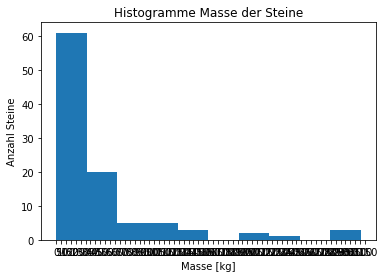

In [47]:
bins = [x for x in range(0,3200,50)]

plt.hist(df3["Masse [kg]"])

plt.xticks(bins)

plt.xlabel("Masse [kg]")
plt.ylabel("Anzahl Steine")
plt.title("Histogramme Masse der Steine")

plt.show()

### Histogram Geschwindigkeit

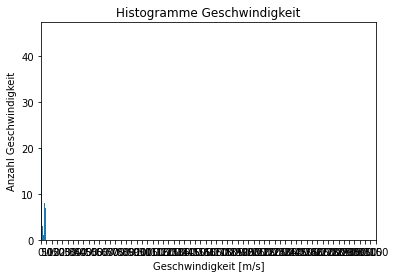

In [48]:
bins = [x for x in range(0,3200,50)]

plt.hist(df3["Geschwindigkeit [m/s]"])

plt.xticks(bins)

plt.xlabel("Geschwindigkeit [m/s]")
plt.ylabel("Anzahl Geschwindigkeit")
plt.title("Histogramme Geschwindigkeit")

plt.show()

### Histogram Energie

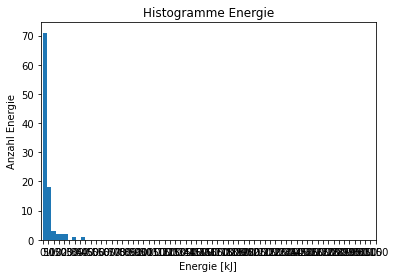

In [49]:
bins = [x for x in range(0,3200,50)]

plt.hist(df3["Energie [kJ]"])

plt.xticks(bins)

plt.xlabel("Energie [kJ]")
plt.ylabel("Anzahl Energie")
plt.title("Histogramme Energie")

plt.show()

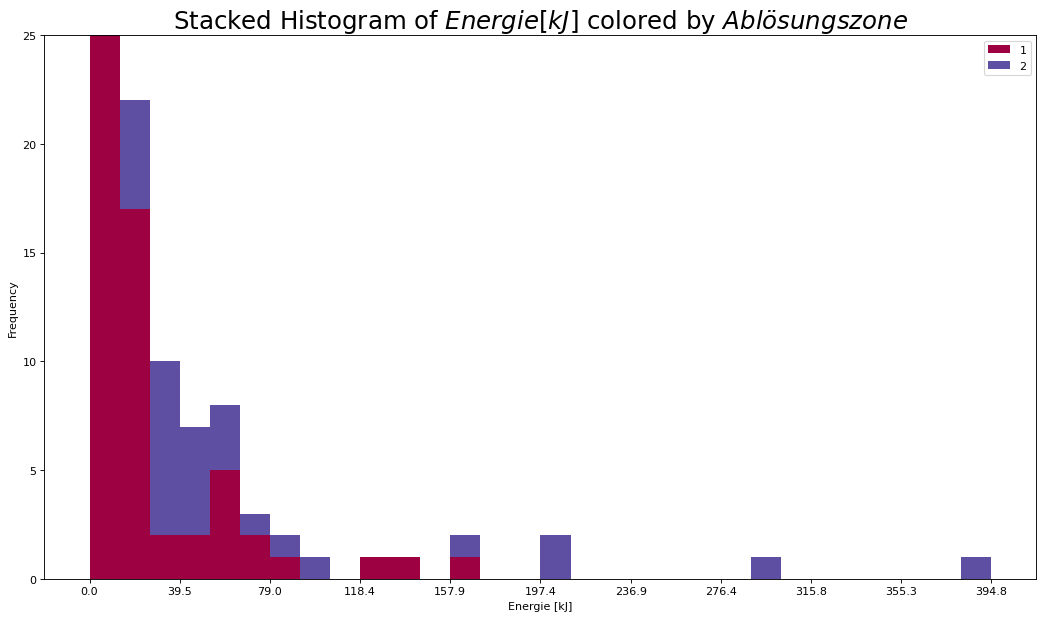

In [50]:
# Prepare data
x_var = 'Energie [kJ]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

### Dot Plot

In [135]:
import seaborn as sns

#### Scatterplot von Geschwindigkeit vs Masse

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


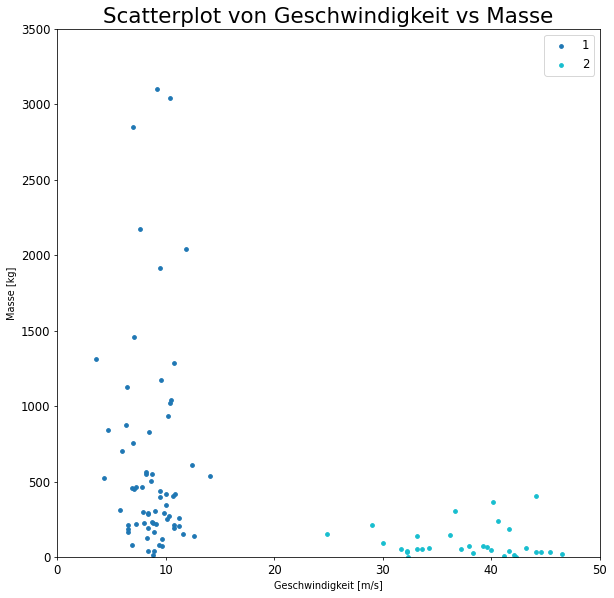

In [153]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### Scatterplot von Geschwindigkeit vs Energie

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


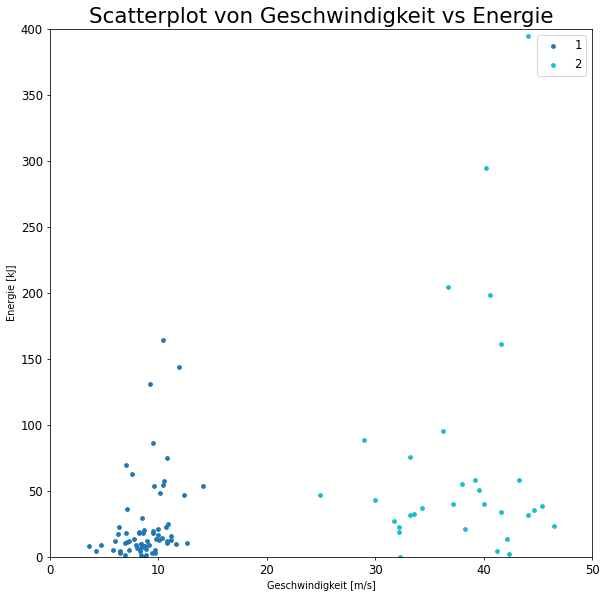

In [154]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Energie [kJ]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 400), xlabel='Geschwindigkeit [m/s]', ylabel='Energie [kJ]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Energie", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### Scatterplot von Energie vs Masse

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


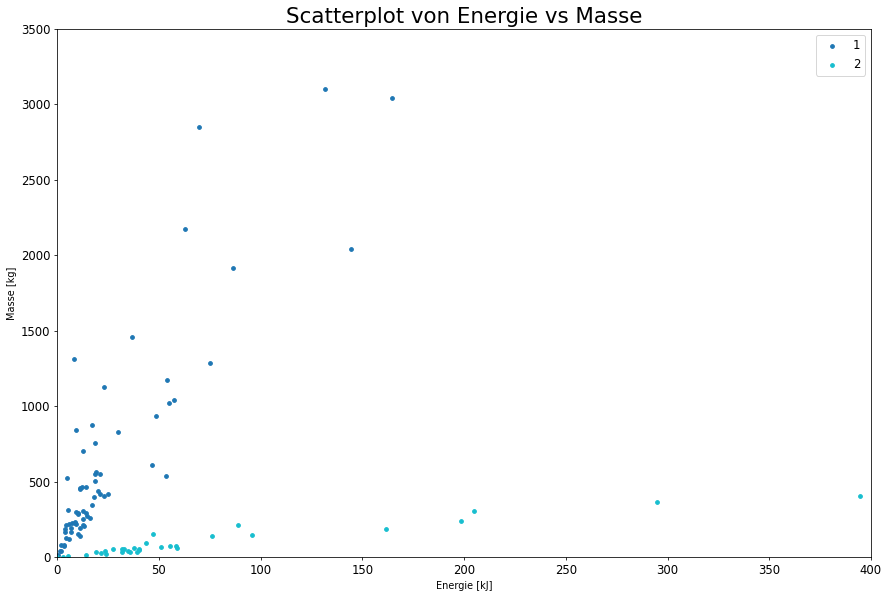

In [155]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(15, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Energie [kJ]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 400), ylim=(0, 3500), xlabel='Energie [kJ]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Energie vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

### Time Plot
https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
Chart 35.